In [1]:
from read_mnist import read_images, read_labels
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_dataset(name):
    def featurize(image):
        return image.astype(float) / 255.0
    images = np.array([featurize(image) for image in read_images(name + '-images-idx3-ubyte')])
    labels = np.array([label for label in read_labels(name + '-labels-idx1-ubyte')])
    return images, labels

In [3]:
import os
test_in, test_out = load_dataset('../data/t10k')
train_in, train_out = load_dataset('../data/train')

def random_batch(inputs, outputs, count=64):
    indices = np.random.randint(0, len(inputs)-1, count)
    return inputs.take(indices, axis=0), outputs.take(indices, axis=0)

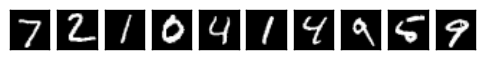

In [4]:
%matplotlib inline
def imshow(im):
    plt.figure()
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
# imshow(test_in[0])
# print test_in[0].shape

def imshow_multi(images):
    f = plt.figure()
    for n, im in enumerate(images):
        f.add_subplot(1, len(images), n+1)  # this line outputs images on top of each other
        # f.add_subplot(1, 2, n)  # this line outputs images side-by-side
        fig = plt.imshow(im, cmap='gray', vmin=0, vmax=1)
        fig.axes.get_xaxis().set_visible(False) # this is the worst api in the world
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

imshow_multi(test_in[:10])

In [5]:
dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')        

def weight_var(shape, stddev=0.1, weight_decay=0, name=None):
    initial = tf.truncated_normal(shape, stddev=stddev)
    v = tf.Variable(initial, name=name)
    if weight_decay > 0:
        l2 = tf.nn.l2_loss(v) * weight_decay
        tf.add_to_collection('losses', l2)
    return v

def leaky_relu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

def relu(x):
    return leaky_relu(x)

def create_fc(input, out_size):
    # input_dropped = tf.nn.dropout(input, dropout_keep_prob)
    in_size = input.get_shape()[-1].value
    w = weight_var([in_size, out_size], weight_decay=0.004)
    b = weight_var([out_size], weight_decay=0.004)
    x = tf.matmul(input, w)
    return relu(x + b)

def create_conv(input, out_channels, patch_size=5, stride=1, batch_norm=False, dropout=False):
    in_channels = input.get_shape()[-1].value
    w = weight_var([patch_size, patch_size, in_channels, out_channels])
    b = weight_var([out_channels], stddev=0)
    conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
    if batch_norm: conv = create_batch_norm(conv)
    activation = relu(conv + b)
    if dropout: activation = create_dropout(activation)
    return activation

def create_deconv(input, input_shape, out_channels, patch_size=5, stride=1, use_relu=True):
    # for best results, patch_size should be a multiple of stride (or vice-versa?)
    input_w, input_h, input_channels = input_shape[-3:]
    
    w = weight_var([patch_size, patch_size, out_channels, input_channels])
    b = weight_var([out_channels], stddev=0)
    
    batch_size = tf.shape(input)[0]
    output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])
    
    deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')
    
    activation = relu(deconv + b) if use_relu else deconv + b
    return activation

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_batch_norm(inputs):
    return batch_norm(inputs, is_training=TRAIN)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

In [6]:
encoded_size = 10
# batch_size = 64

def encoder(images):
    images = tf.reshape(images, [-1, 28, 28, 1])
    images = create_conv(images, 32, patch_size=5, stride=2)
    images = create_conv(images, 32, patch_size=5, stride=2) # now 7x7x32
    images = tf.reshape(images, [-1, 7*7*32])
    fc1 = create_fc(images, 1500)
    # fc1 = create_dropout(fc1)
    z_mean = create_fc(fc1, encoded_size)
    z_stddev = create_fc(fc1, encoded_size)
    return z_mean, z_stddev

def decoder(vectors):
    fc1 = create_fc(vectors, 1500)
    fc2 = create_fc(fc1, 7*7*32)
    images = tf.reshape(fc2, [-1, 7, 7, 32])
    
    dc1 = create_deconv(images, [7,7,32], 16, patch_size=2, stride=2) # now 14x14x16
    dc2 = create_deconv(dc1, [14,14,16], 1, patch_size=2, stride=2, use_relu=False) # now 28x28x1
    dc2 = tf.sigmoid(dc2)
    return tf.reshape(dc2, [-1, 28, 28])

def sample_z(z_mean, z_stddev):
    samples = tf.random_normal(tf.shape(z_stddev), 0, 1, dtype=tf.float32)
    return z_mean + samples * z_stddev


In [7]:
images = tf.placeholder(tf.float32, [None, 28, 28], name='images')
z_mean, z_stddev = encoder(images)
z_vals = sample_z(z_mean, z_stddev)

z_input = tf.placeholder(tf.float32, [None, encoded_size], name='z_input')
use_z_input = tf.placeholder(tf.int32, shape=[], name="use_z_input_condition")
decoder_input = tf.cond(use_z_input > 0, lambda: z_input, lambda: z_vals)

reconstructions = decoder(decoder_input)
use_log_loss = False # this seems to cause nan loss ...?
if use_log_loss:
    images_flat = tf.reshape(images, [-1, 28*28])
    reconstructions_flat = tf.reshape(reconstructions, [-1, 28 * 28])
    image_similarity_loss = -tf.reduce_sum(images_flat * tf.log(1e-8 + reconstructions_flat) + (1-images_flat) * tf.log(1e-8 + 1 - reconstructions_flat) ,1)
    image_similarity_loss = tf.reduce_mean(image_similarity_loss)
else:
    image_similarity_loss = tf.reduce_mean(tf.nn.l2_loss(tf.reshape(images, [-1, 28*28]) - tf.reshape(reconstructions, [-1, 28*28])))
kl_divergence = tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1, 1))
loss = image_similarity_loss + kl_divergence

random_vecs = tf.random_normal([16, encoded_size], 0, 1, dtype=tf.float32)

In [8]:
learn_rate = tf.placeholder(tf.float32, name='learning_rate')
optimizer = tf.train.AdamOptimizer(learn_rate)
global_step = tf.contrib.framework.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)

In [9]:
save_path = 'models/mva2'

session = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Restored from checkpoint models/mva2/model.ckpt-1500


In [11]:
for i in xrange(1000000):
    global_step_ = session.run(global_step)
    ti, tl = random_batch(train_in, train_out, count=256)
    
    learn_rate_ = 0.001
    if global_step_ > 5000:
        learn_rate_ = 0.0001
    
    feed_dict = {
        dropout_keep_prob: 0.5, 
        images: ti,
        use_z_input: 0,
        z_input: np.zeros(shape=(0, encoded_size)),
        learn_rate: learn_rate_}
    loss_, global_step_, _ = session.run([loss, global_step, train_step], feed_dict=feed_dict)
    
    if global_step_ % 100 == 0:
        print 'Step: {}, learn rate: {}, loss: {}'.format(global_step_, learn_rate_, loss_)
        if saver and global_step_ % 500 == 0:
            saver.save(session, save_path + '/model.ckpt', global_step=global_step_)
            print 'Saved'


Step: 100, learn rate: 0.001, loss: 3626.59521484
Step: 200, learn rate: 0.001, loss: 2974.48901367
Step: 300, learn rate: 0.001, loss: 2626.23779297
Step: 400, learn rate: 0.001, loss: 2305.30664062
Step: 500, learn rate: 0.001, loss: 2409.29003906
Saved
Step: 600, learn rate: 0.001, loss: 2419.12280273
Step: 700, learn rate: 0.001, loss: 2088.93310547
Step: 800, learn rate: 0.001, loss: 2421.25170898
Step: 900, learn rate: 0.001, loss: 2088.87207031
Step: 1000, learn rate: 0.001, loss: 2287.10229492
Saved
Step: 1100, learn rate: 0.001, loss: 1976.65808105
Step: 1200, learn rate: 0.001, loss: 1949.72607422
Step: 1300, learn rate: 0.001, loss: 1749.30273438
Step: 1400, learn rate: 0.001, loss: 1770.34277344
Step: 1500, learn rate: 0.001, loss: 1817.59130859
Saved
Step: 1600, learn rate: 0.001, loss: 1675.75683594
Step: 1700, learn rate: 0.001, loss: 1800.18798828
Step: 1800, learn rate: 0.001, loss: 1890.37573242
Step: 1900, learn rate: 0.001, loss: 2101.77905273


KeyboardInterrupt: 

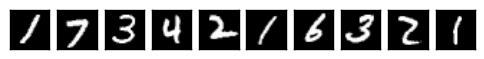

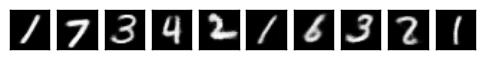

In [12]:
%matplotlib inline

def reconstruction_demo():
    ti, tl = random_batch(train_in, train_out, count=10)
    # imshow(ti[0])
    feed_dict = {
        dropout_keep_prob: 1,
        use_z_input: 0,
        z_input: np.zeros((0, encoded_size)),
        images: ti
    }
    reconstructed = session.run(reconstructions, feed_dict=feed_dict)
    imshow_multi(ti)
    imshow_multi(reconstructed)

reconstruction_demo()

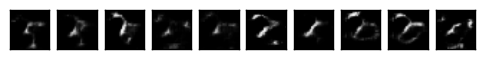

In [21]:
%matplotlib inline

def generation_demo():
    rand = np.random.normal(size=(16, encoded_size))
    feed_dict = {
        use_z_input: 1,
        z_input: rand,
        images: np.zeros((0, 28, 28))
    }
    images_ = session.run(reconstructions, feed_dict=feed_dict)
    imshow_multi(images_[:10])

generation_demo()

In [11]:
ti, tl = random_batch(train_in, train_out, count=16)
for vec in session.run(z_vals, feed_dict={images: ti}):
    print vec

[ 5.50972652  0.46766824  2.48728442  1.71777141  0.44927651  3.16284323
  3.76665998 -2.93620014 -1.27996302  1.05184591]
[ 4.16117859  2.51626611  4.85881281  2.96656823 -0.03133375  0.79681724
  3.29458308  1.32304287  4.39395094  5.74068451]
[ 2.07452369  0.549528    4.79504347  7.09625387  2.87136245  3.77796531
  5.73144388 -0.49003765  3.79606915 -0.75874317]
[ 9.74973297  1.23781765  2.74592471  7.47834969  4.77851725  3.36044383
  1.10687459 -2.58537769 -0.53342634  5.57272959]
[-0.52251011  2.63840866  7.58703995  3.07208514  5.62446499 -0.28510398
  6.35791731 -1.08272314  0.04777831  0.88749641]
[ 0.86131221  3.78881216  0.24704948 -0.06277622  0.11256009  0.24238397
 -0.08645609  0.54086167  6.01901293  1.69932652]
[ 3.4191215   3.39315414  3.5098989   4.23779202  4.20887232  5.07336426
  0.07902446 -2.34544611  4.84207439  5.17160988]
[ 1.3043797   2.66852355  0.79584235  5.3798008   3.23818445  0.36497191
  4.7644043  -0.50749695  5.21184111  1.37258863]
[ 9.90791416 -0.

[[ 1.21247959  1.53361011  1.61471784  3.96641254  2.69023848  4.05767488
   5.34224939 -7.95813751 -0.0837506   5.23074532]
 [ 1.49431205  0.98597068  1.86497402  4.47098923  2.58632708  3.64798379
   5.1012249  -6.89040804  0.6463843   4.6715498 ]
 [ 1.77614427  0.43833125  2.11523008  4.97556543  2.48241544  3.23829246
   4.86020088 -5.82267809  1.3765192   4.11235428]
 [ 2.05797672 -0.10930818  2.36548615  5.48014164  2.37850404  2.82860136
   4.61917639 -4.75494862  2.10665393  3.55315876]
 [ 2.33980894 -0.65694773  2.61574221  5.98471832  2.2745924   2.41891003
   4.37815189 -3.68721867  2.83678889  2.99396324]
 [ 2.6216414  -1.2045871   2.86599851  6.48929453  2.170681    2.00921893
   4.1371274  -2.61948895  3.5669241   2.43476748]
 [ 2.90347362 -1.75222659  3.11625433  6.99387074  2.0667696   1.5995276
   3.89610291 -1.55175912  4.29705858  1.87557185]
 [ 3.18530607 -2.29986596  3.36651039  7.49844694  1.96285796  1.18983638
   3.65507841 -0.48402938  5.02719355  1.31637621]]


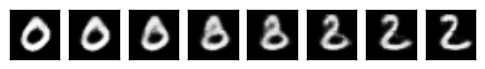

In [15]:
def find_digit(n):
    for im, label in zip(test_in, test_out):
        if label == n:
            return im

def blend_demo(digit1, digit2):
    im1 = find_digit(digit1)
    im2 = find_digit(digit2)
    feed_dict = {
        use_z_input: 0,
        z_input: np.zeros((0, encoded_size)),
        images: np.array([im1, im2])
    }
    v1, v2 = session.run(z_vals, feed_dict=feed_dict)
    steps = 7
    def blend(p):
        return v1 * (1-p) + v2 * p
    feed_dict = {
        use_z_input: 1,
        z_input: np.array([blend(s * 1.0 / steps) for s in range(steps+1)]),
        images: np.zeros((0, 28, 28))
    }
    print np.array([blend(s * 1.0 / steps) for s in range(steps+1)])
    # print 'ok'
    reconstructed = session.run(reconstructions, feed_dict=feed_dict)
    imshow_multi(reconstructed)

blend_demo(0, 2)